# RO1
**1. Examining factors that influence working over the required working hours and under the required working hours.**

2. Conducting association rule analysis to identify factors influencing the mismatch between highest qualifications and employment qualifications.

3. Investigating how individuals address the skill gap when they lack the necessary qualifications in their current profession

In [1]:
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data

In [5]:
df = pd.read_csv('data_sorted.csv')
codebook = pd.read_excel('PIAAC\Cycle 1\International Codebook_PIAAC Public-use File (PUF) Variables and Values.xlsx')

print(df.shape)
df.head()

C:\Users\Anis\AppData\Local\Temp\ipykernel_31456\2046365629.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_sorted.csv')


(11470, 93)


,Skill use work - ICT - Computer - How often - Programming language,ISCO1C,Skill use work - ICT - Computer - How often - Real-time discussions,Skill use work - How often - Organising own time,Skill use everyday life - ICT - Computer - How often - Word,Skill use work - How often - Planning others activities,PVPSL6,About yourself - Learning strategies - Attribute something new,ICTHOME,PVPSL8,...,Education - Highest qualification - Level,PVPSL4,PVPSL10,Skill use everyday life - ICT - Internet - How often - In order to better understand various issues,About yourself - Learning strategies - Get to the bottom of difficult things,WorkHours,WorkHours_Difference,Qualification_Comparision,Qualification_Status,PVPSL_Performance
0,At least once a week but not every day,Service workers and shop and market sales workers,Less than once a month,Every day,Less than once a week but at least once a month,Never,315.18911,To a high extent,2.021940,296.26412,...,"ISCED 5A, bachelor degree",342.29315,318.98045,Less than once a week but at least once a month,To a high extent,Over Average,18,Over by 5 level(s),Over,Moderate performer
1,Less than once a week but at least once a month,Professionals,Never,Every day,Never,Less than once a month,326.64999,To some extent,1.646234,273.53912,...,"ISCED 5A, bachelor degree",325.28718,296.98809,At least once a week but not every day,To a high extent,Over Average,8,Equal,Equal,Moderate performer
2,Never,"Legislators, senior officials and managers",At least once a week but not every day,Every day,At least once a week but not every day,At least once a week but not every day,285.41693,To some extent,3.430657,279.23163,...,"ISCED 5A, bachelor degree",316.26258,249.59748,Every day,Very little,Over Average,18,Under by 2 level(s),Under,Weak performer
3,Never,Service workers and shop and market sales workers,Never,Less than once a month,Less than once a month,Never,332.55340,To a high extent,1.623673,284.82134,...,ISCED 5B,318.41257,325.03424,At least once a week but not every day,To some extent,Under Average,-15,Over by 5 level(s),Over,Moderate performer
4,Never,Technicians and associate professionals,Never,Never,Never,Never,300.41854,To some extent,1.365424,290.70099,...,ISCED 3C 2 years or more,307.69612,307.37447,Less than once a month,Very little,Under Average,-10,Over by 1 level(s),Over,Moderate performer


In [6]:
# variables

# dropped AGE_R, ISCO2C
demographic_var = ['CNTRYID', 'AGE_R', 'GENDER_R', 'LNG_HOME', 'NATIVELANG', 'NATIVESPEAKER', 'J_Q06b', 'J_Q07b', 'I_Q08', 'J_Q04a']
eduwork_var = ['CNTRYID', 'C_Q07', 'C_D06', 'B_Q01a', 'B_Q01a3', 'B_Q01b', 'D_Q12a', 'B_Q05c', 'B_Q10c', 'D_Q14', 'ISCOSKIL4', 'ISCO1C', 'D_Q10', 'D_Q03', 'D_Q04', 'D_Q07a', 'D_Q07b', 'D_Q08a', 'D_Q08b', 'VET', 'NFEHRS']

worksl_var = ['CNTRYID', 'ICTWORK', 'NFEHRSJR']
worksl_var.extend(codebook.loc[codebook['Name'].str.startswith('F_'), 'Name'].tolist())
worksl_var.extend(codebook.loc[codebook['Name'].str.startswith('G_') & codebook['Label'].str.contains('ICT'), 'Name'].tolist())

lifesl_var = ['CNTRYID', 'ICTHOME', 'NFEHRSNJR']
lifesl_var.extend(codebook.loc[codebook['Name'].str.startswith('H_') & codebook['Label'].str.contains('ICT'), 'Name'].tolist())
lifesl_var.extend(codebook.loc[codebook['Name'].str.startswith('I_') & codebook['Label'].str.contains('Learning'), 'Name'].tolist())

pvpsl = []
pvpsl.extend(codebook.loc[codebook['Name'].str.startswith('PVPSL'), 'Name'].tolist())


vars = list(set(demographic_var + eduwork_var + worksl_var + lifesl_var + pvpsl))
vars_keep = [var for var in vars if not (var[0].isalpha() and var[1] == '_')]
vars_change = [var for var in vars if var[0].isalpha() and var[1] == '_']

vars_dict = {}

for i in vars_change:
    match = codebook.loc[codebook['Name'] == i, 'Label'].tolist()
    if match:
        vars_dict[i] = match[0]


demographic_mapped = [vars_dict.get(value, value) if value is not None else None for value in demographic_var]
eduwork_mapped = [vars_dict.get(value, value) if value is not None else None for value in eduwork_var]
worksl_mapped = [vars_dict.get(value, value) if value is not None else None for value in worksl_var]
lifesl_mapped = [vars_dict.get(value, value) if value is not None else None for value in lifesl_var]

hours_var = ['WorkHours', 'WorkHours_Difference']
match_var = ['Qualification_Comparision', 'Qualification_Status']
performance_var = 'PVPSL_Performance'

print(len(demographic_mapped) + len(eduwork_mapped) + len(worksl_mapped) + len(lifesl_mapped) + len(hours_var) + len(match_var) + len(performance_var))

101


# Data Setup

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [8]:
sns.set_palette("dark")
sns.set_style('darkgrid')
sns.set(font_scale=1.1)

In [9]:
countries = df['CNTRYID'].unique()
# 'NFEHRS', 'NFEHRSJR', 'NFEHRSNJR'
drop = ['AGE_R', 'ISCO2C', 'WorkHours_Difference', 'Current work - Hours/week'] + pvpsl
df2 = df.drop(columns=drop).copy()

In [10]:
target = ['WorkHours']
df3 = df2[df2['WorkHours'] != 'Average']

X = df3.drop(columns=target)
y = df3[target]
feature_names = X.columns

class_labels = df3['WorkHours'].unique().tolist()

In [11]:
print(df.shape) # raw
print(df2.shape) # after fs
print(df3.shape) # only above/below average

df3[target].value_counts()

(11470, 93)
(11470, 79)
(6597, 79)


WorkHours    
Under Average    3347
Over Average     3250
Name: count, dtype: int64

In [12]:
sizes = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
imputer = SimpleImputer(strategy='most_frequent')

cat = X.select_dtypes(include = 'object').columns

In [13]:
report_items = ['precision', 'recall', 'f1-score', 'support']

# evaluation function
def getEvaluationMetrics(y_test, y_pred, y_proba):
    evals = []
    evals_score = [] # for tables
    
    # accuracy score
    score = accuracy_score(y_test, y_pred)
    evals.append(score)
    evals_score.append(score)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    evals.append(cm)
    
    # classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)
    evals.append(report)
    
    report_dict = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    for i in class_labels:
        for item in report_items:
            evals_score.append(report_dict[i][item])
    
    # roc auc
    auc = roc_auc_score(y_test, y_proba)
    evals.append(auc)
    evals_score.append(auc)
    
    return evals, evals_score

In [14]:
def showEvaluationMetrics(evals, text=''):
    acc = 'Accuracy score'
    cm =  'Confusion matrix'
    rep = 'Classification report'
    roc = 'AUC ROC score'
    
    if text != '':
        acc = acc + ' for ' + text
        cm = cm + ' for ' + text
        rep = rep + ' for ' + text
        roc = roc + ' for ' + text

        print(acc, ' : ', evals[0])
        
        sns.heatmap(evals[1], annot=True, fmt='g', 
                xticklabels=class_labels,
                yticklabels=class_labels,)
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.title(cm)
        plt.show()
        
        print(rep, ' : ')
        print(evals[2])
        
        print(roc, ':', evals[3])
    else:
        print(acc, ' : ', evals[0])
        
        sns.heatmap(evals[1], annot=True, fmt='g', 
                xticklabels=class_labels,
                yticklabels=class_labels,)
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.title(cm)
        plt.show()
        
        print(rep, ' : ')
        print(evals[2])
        
        print(roc, ':', evals[3])

In [15]:
X_train_enc_list = []
X_test_enc_list = []
y_train_list = []
y_test_list = []

for size in sizes:
    # encoding
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=5)
    
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    X_train_enc = X_train.copy()
    X_test_enc = X_test.copy()
    
    X_train_enc[cat] = enc.fit_transform(X_train_enc[cat])
    X_test_enc[cat] = enc.transform(X_test_enc[cat])
    
    X_train_enc[cat] = imputer.fit_transform(X_train_enc[cat])
    X_test_enc[cat] = imputer.transform(X_test_enc[cat])
    
    X_train_enc_list.append(X_train_enc)
    X_test_enc_list.append(X_test_enc)

## Random Forest Classifier

### Best Accuracy

In [16]:
# 5-6 min runtime

n_vals = [i for i in range(5, 105, 5)]
criterions = ['gini', 'entropy', 'log_loss']

scores_dict = {}

for cri in criterions:
    scores_dict[cri] = {}
    
    for size in sizes:
        scores_dict[cri][size] = []
        index = sizes.index(size)
        
        scores = []

        for n in n_vals:
            rf = RandomForestClassifier(n_estimators=n, criterion=cri, random_state=5)
            rf.fit(X_train_enc_list[index], y_train_list[index])
            
            score = rf.score(X_test_enc_list[index], y_test_list[index]) # same as accuracy_score, this just simplifies the whole process
            
            scores_dict[cri][size].append(score)

Current criterion:  gini
Test size:  0.05  - Highest scoring:  0.7363636363636363  at n_val =  35
Test size:  0.1  - Highest scoring:  0.7393939393939394  at n_val =  85
Test size:  0.15  - Highest scoring:  0.7565656565656566  at n_val =  60
Test size:  0.2  - Highest scoring:  0.7492424242424243  at n_val =  65
Test size:  0.25  - Highest scoring:  0.7321212121212122  at n_val =  20
Test size:  0.3  - Highest scoring:  0.7434343434343434  at n_val =  80


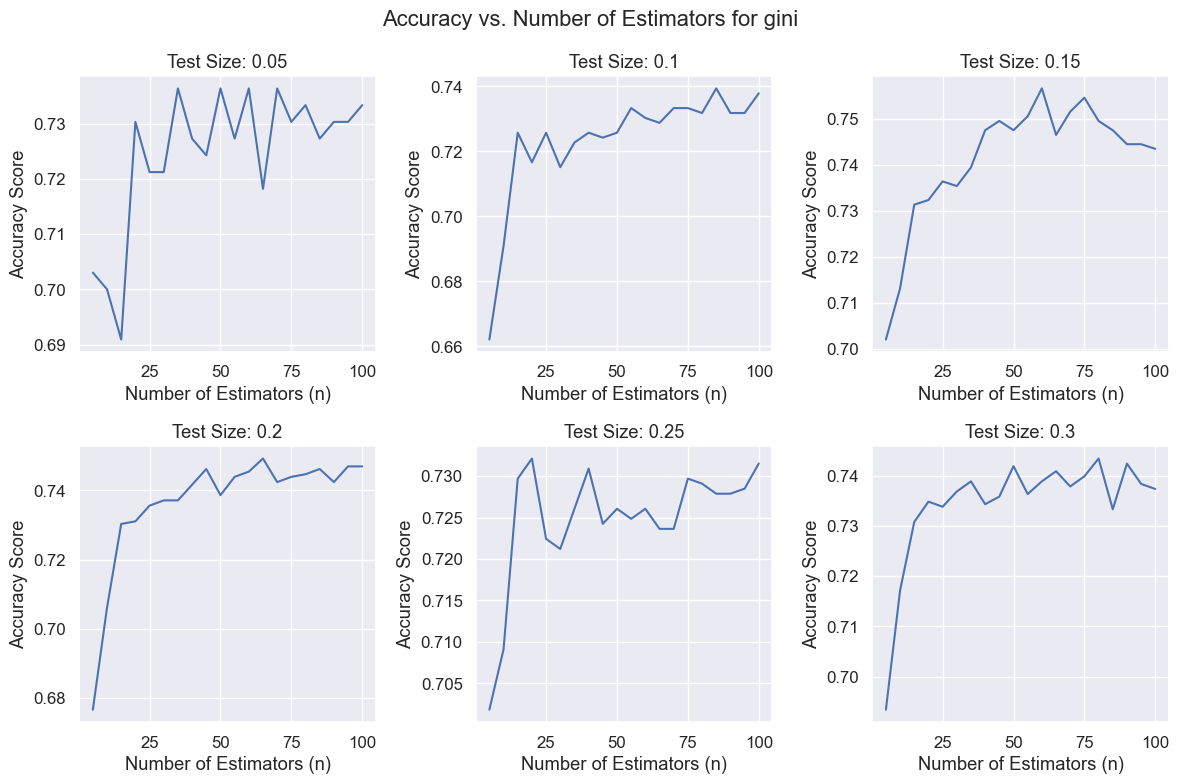

Current criterion:  entropy
Test size:  0.05  - Highest scoring:  0.7454545454545455  at n_val =  25
Test size:  0.1  - Highest scoring:  0.7333333333333333  at n_val =  100
Test size:  0.15  - Highest scoring:  0.7525252525252525  at n_val =  70
Test size:  0.2  - Highest scoring:  0.7522727272727273  at n_val =  100
Test size:  0.25  - Highest scoring:  0.7448484848484849  at n_val =  60
Test size:  0.3  - Highest scoring:  0.7434343434343434  at n_val =  95


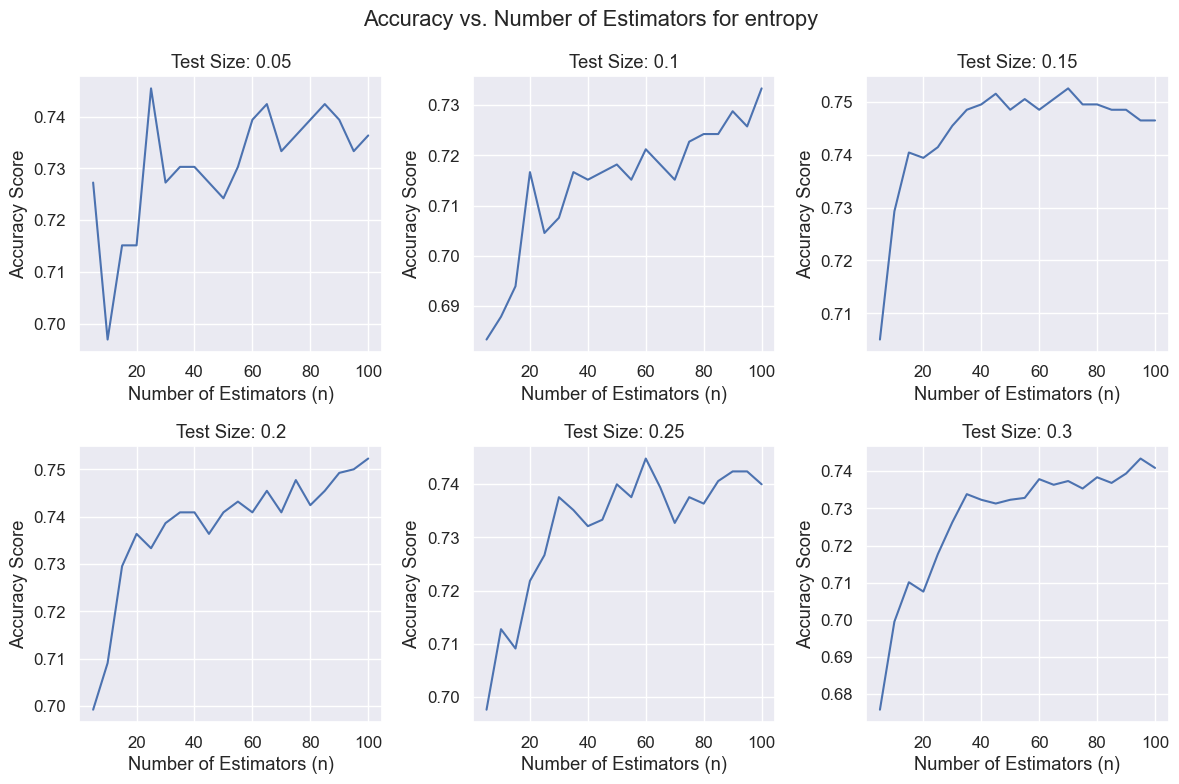

Current criterion:  log_loss
Test size:  0.05  - Highest scoring:  0.7454545454545455  at n_val =  25
Test size:  0.1  - Highest scoring:  0.7333333333333333  at n_val =  100
Test size:  0.15  - Highest scoring:  0.7525252525252525  at n_val =  70
Test size:  0.2  - Highest scoring:  0.7522727272727273  at n_val =  100
Test size:  0.25  - Highest scoring:  0.7448484848484849  at n_val =  60
Test size:  0.3  - Highest scoring:  0.7434343434343434  at n_val =  95


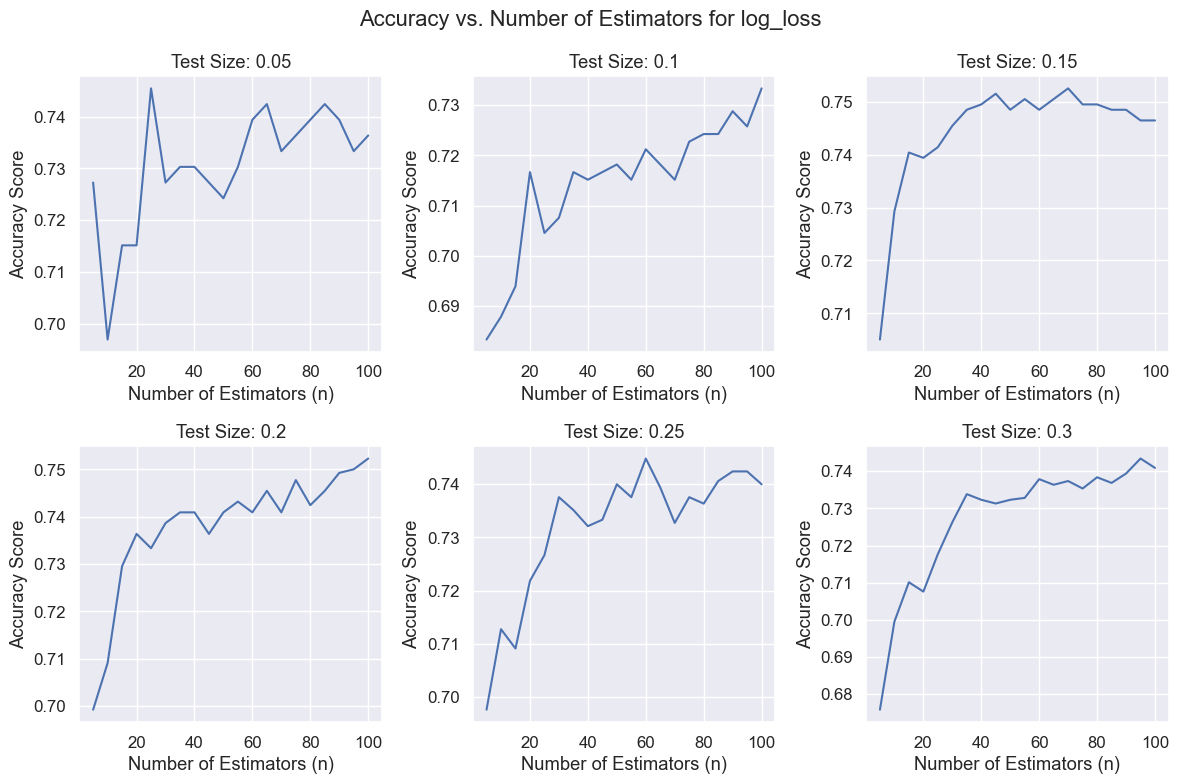

In [17]:
# get max score from all test sizes
# use ccv for more fair testing

rows = int(len(sizes)/3)

all_top_scores = []
top_scores = {}

for cri, inner in scores_dict.items():
    max_score = 0
    max_size = 0
    max_nval = 0
        
    plt.figure(figsize=(12, 8))
    curr_row = 1
    
    print('Current criterion: ', cri)
    
    for i, (size, scoring) in enumerate(inner.items()):
        
        if i >= 3:
            curr_row = 2
        
        ax = plt.subplot(rows, 3, i + 1)
        ax.plot(n_vals, scoring)
        ax.set_xlabel('Number of Estimators (n)')
        ax.set_ylabel('Accuracy Score')
        ax.set_title('Test Size: ' + str(size))
        
        print('Test size: ', size, ' - Highest scoring: ', np.max(scoring), ' at n_val = ', n_vals[np.argmax(scoring)])
        all_top_scores.append((str(cri), size, np.max(scoring), n_vals[np.argmax(scoring)]))
        
        # get top
        curr_max = np.max(scoring)
        if curr_max > max_score:
            max_score = curr_max
            max_size = size
            max_n_val = n_vals[np.argmax(scoring)]
        
        top_scores[cri] = {'Test size': max_size, 'Accuracy': max_score, 'n_val': max_n_val}
        
    plt.suptitle('Accuracy vs. Number of Estimators for ' + cri)
    plt.tight_layout()
    plt.show()

In [18]:
rfc_all_scores_df = pd.DataFrame(all_top_scores, columns=['Criterion', 'Test size', 'Highest Accuracy Score', 'n_val of Highest Accuracy Score'])
rfc_all_scores_df.to_csv('RQ1/RandomForestClassifier_AllAccuracyScores.csv', index=False)
display(rfc_all_scores_df)

,Criterion,Test size,Highest Accuracy Score,n_val of Highest Accuracy Score
0,gini,0.05,0.736364,35
1,gini,0.10,0.739394,85
2,gini,0.15,0.756566,60
3,gini,0.20,0.749242,65
4,gini,0.25,0.732121,20
5,gini,0.30,0.743434,80
6,entropy,0.05,0.745455,25
7,entropy,0.10,0.733333,100
8,entropy,0.15,0.752525,70
9,entropy,0.20,0.752273,100


In [19]:
rfc_top_scores = top_scores.copy()
top_scores

{'gini': {'Test size': 0.15, 'Accuracy': 0.7565656565656566, 'n_val': 60},
 'entropy': {'Test size': 0.15, 'Accuracy': 0.7525252525252525, 'n_val': 70},
 'log_loss': {'Test size': 0.15, 'Accuracy': 0.7525252525252525, 'n_val': 70}}

### Feature Importance and Classification Matrices of Top Scores for Each Criterion

Accuracy score for Random Forest Classifier - gini  :  0.7565656565656566


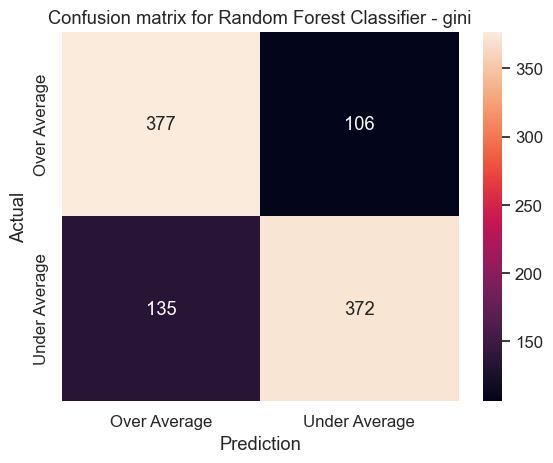

Classification report for Random Forest Classifier - gini  : 
               precision    recall  f1-score   support

 Over Average       0.74      0.78      0.76       483
Under Average       0.78      0.73      0.76       507

     accuracy                           0.76       990
    macro avg       0.76      0.76      0.76       990
 weighted avg       0.76      0.76      0.76       990

AUC ROC score for Random Forest Classifier - gini : 0.8285289589637416
----------------------------------------------------------------------------------------------------
Accuracy score for Random Forest Classifier - entropy  :  0.7525252525252525


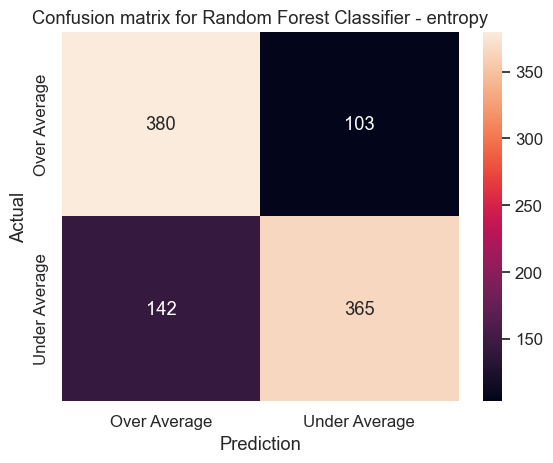

Classification report for Random Forest Classifier - entropy  : 
               precision    recall  f1-score   support

 Over Average       0.73      0.79      0.76       483
Under Average       0.78      0.72      0.75       507

     accuracy                           0.75       990
    macro avg       0.75      0.75      0.75       990
 weighted avg       0.75      0.75      0.75       990

AUC ROC score for Random Forest Classifier - entropy : 0.8218216194804824
----------------------------------------------------------------------------------------------------
Accuracy score for Random Forest Classifier - log_loss  :  0.7525252525252525


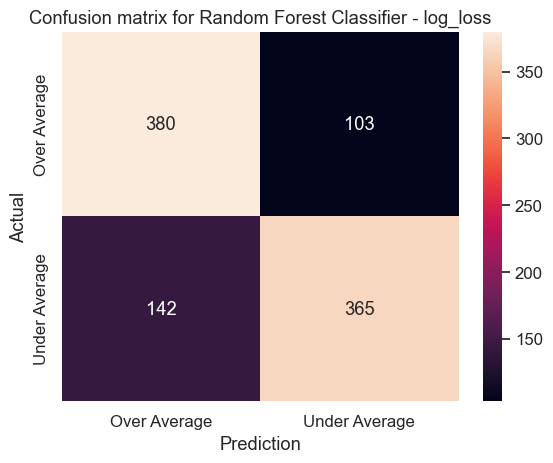

Classification report for Random Forest Classifier - log_loss  : 
               precision    recall  f1-score   support

 Over Average       0.73      0.79      0.76       483
Under Average       0.78      0.72      0.75       507

     accuracy                           0.75       990
    macro avg       0.75      0.75      0.75       990
 weighted avg       0.75      0.75      0.75       990

AUC ROC score for Random Forest Classifier - log_loss : 0.8218216194804824
----------------------------------------------------------------------------------------------------


In [20]:
#  feature_importances with top scores

feature_df_list = []
eval_scores_list = []

for cri, inner in top_scores.items():
    test_size = inner['Test size']
    
    for index, size in enumerate(sizes):
        if size == test_size:
            X_train_enc = X_train_enc_list[index]
            X_test_enc = X_test_enc_list[index]
            y_train = y_train_list[index]
            y_test = y_test_list[index]
            break
    
    rf = RandomForestClassifier(n_estimators=inner['n_val'], criterion=cri, random_state=5)
    rf.fit(X_train_enc, y_train)
    
    y_pred = rf.predict(X_test_enc)
    y_proba = rf.predict_proba(X_test_enc)[:, 1]
    
    eval, eval_scores = getEvaluationMetrics(y_test, y_pred, y_proba)
    showEvaluationMetrics(eval, ('Random Forest Classifier - ' + cri))
    print('-' * 100)
    eval_scores_list.append(eval_scores)
    
    # feature importances
    importances = rf.feature_importances_
    
    col_cri = 'Features_' + str(cri)
    col_imp = 'Importance_' + str(cri)
    
    features_df = pd.DataFrame({col_cri: feature_names, col_imp: importances}).sort_values(col_imp, ascending=False).reset_index(drop=True)
    feature_df_list.append(features_df)

In [21]:
eval_cols = ['Accuracy',
             'OverAverage_precision', 'OverAverage_recall', 'OverAverage_f1-score', 'OverAverage_support',
             'UnderAverage_precision', 'UnderAverage_recall', 'UnderAverage_f1-score', 'UnderAverage_support',
             'AUC_ROC_score']

rfc_top_scores_eval_df = pd.DataFrame(eval_scores_list, columns=eval_cols, index=criterions)
rfc_top_scores_eval_df.to_csv('RQ1/RandomForestClassifier_TopAccuracy_Evaluation.csv')
display(rfc_top_scores_eval_df)

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
gini,0.756566,0.736328,0.780538,0.757789,483,0.778243,0.733728,0.755330,507,0.828529
entropy,0.752525,0.727969,0.786749,0.756219,483,0.779915,0.719921,0.748718,507,0.821822
log_loss,0.752525,0.727969,0.786749,0.756219,483,0.779915,0.719921,0.748718,507,0.821822


In [22]:
rfc_importance_df = pd.DataFrame()
for i in feature_df_list:
    rfc_importance_df = pd.concat([rfc_importance_df, i], axis=1)

rfc_importance_df.to_csv('RQ1/RandomForestClassifier_TopAccuracy_Importance.csv', index=False)
display(rfc_importance_df)

,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current status/work history - Subjective status,0.104349,Current status/work history - Subjective status,0.093441,Current status/work history - Subjective status,0.093441
1,GENDER_R,0.039295,GENDER_R,0.031380,GENDER_R,0.031380
2,ICTHOME,0.030366,ICTHOME,0.031114,ICTHOME,0.031114
3,ICTWORK,0.028993,ICTWORK,0.028774,ICTWORK,0.028774
4,Education - Highest qualification - Area of study,0.024812,Education - Highest qualification - Area of study,0.024597,Education - Highest qualification - Area of study,0.024597
...,...,...,...,...,...,...
73,NATIVESPEAKER,0.002575,Current work - Employee or self-employed,0.002440,Current work - Employee or self-employed,0.002440
74,Skill use everyday life - ICT - Ever used comp...,0.001611,Skill use everyday life - ICT - Experience wit...,0.001518,Skill use everyday life - ICT - Experience wit...,0.001518
75,Skill use everyday life - ICT - Experience wit...,0.001450,Skill use everyday life - ICT - Ever used comp...,0.001312,Skill use everyday life - ICT - Ever used comp...,0.001312
76,Skill use work - ICT - Experience with compute...,0.001432,Skill use work - ICT - Experience with compute...,0.001196,Skill use work - ICT - Experience with compute...,0.001196


## Decision Tree
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/tree.html

In [23]:
from sklearn.tree import DecisionTreeClassifier

### Best Accuracy

In [24]:
# runtime = 1s

criterions = ['gini', 'entropy', 'log_loss']

scores_dict = {}

for cri in criterions:
    scores_dict[cri] = {}
    
    for size in sizes:
        scores_dict[cri][size] = []
        index = sizes.index(size)
        
        model = DecisionTreeClassifier(criterion=cri, random_state=5)
        model.fit(X_train_enc_list[index], y_train_list[index])
        
        score = model.score(X_test_enc_list[index], y_test_list[index]) # same as accuracy_score, this just simplifies the whole process
        scores_dict[cri][size] = score

In [25]:
all_scores = []
top_scores = {}

for cri, inner in scores_dict.items():
    max_size = 0
    max_score = 0
    
    print(cri)
    
    for size, acc in inner.items():

        print(size, '-', acc)
        all_scores.append((str(cri), str(size), acc))
        
        if acc > max_score:
            max_score = acc
            max_size = size
    top_scores[cri] = {'Test size': max_size, 'Accuracy': max_score}
    print()

print('Top Scores')
dt_top_scores = top_scores.copy()

print(top_scores)

gini
0.05 - 0.6666666666666666
0.1 - 0.6363636363636364
0.15 - 0.6656565656565656
0.2 - 0.6492424242424243
0.25 - 0.6612121212121213
0.3 - 0.6474747474747474

entropy
0.05 - 0.6757575757575758
0.1 - 0.646969696969697
0.15 - 0.6636363636363637
0.2 - 0.646969696969697
0.25 - 0.6521212121212121
0.3 - 0.6484848484848484

log_loss
0.05 - 0.6757575757575758
0.1 - 0.646969696969697
0.15 - 0.6636363636363637
0.2 - 0.646969696969697
0.25 - 0.6521212121212121
0.3 - 0.6484848484848484

Top Scores
{'gini': {'Test size': 0.05, 'Accuracy': 0.6666666666666666}, 'entropy': {'Test size': 0.05, 'Accuracy': 0.6757575757575758}, 'log_loss': {'Test size': 0.05, 'Accuracy': 0.6757575757575758}}


In [26]:
dt_all_scores_df = pd.DataFrame(all_scores, columns=['Criterion', 'Test size', 'Highest Accuracy Score'])
dt_all_scores_df.to_csv('RQ1/DecisionTree_AllAccuracyScores.csv', index=False)
display(dt_all_scores_df)

,Criterion,Test size,Highest Accuracy Score
0,gini,0.05,0.666667
1,gini,0.1,0.636364
2,gini,0.15,0.665657
3,gini,0.2,0.649242
4,gini,0.25,0.661212
5,gini,0.3,0.647475
6,entropy,0.05,0.675758
7,entropy,0.1,0.646970
8,entropy,0.15,0.663636
9,entropy,0.2,0.646970


### Feature Importance

Accuracy score for Decision Tree Classifier - gini  :  0.6666666666666666


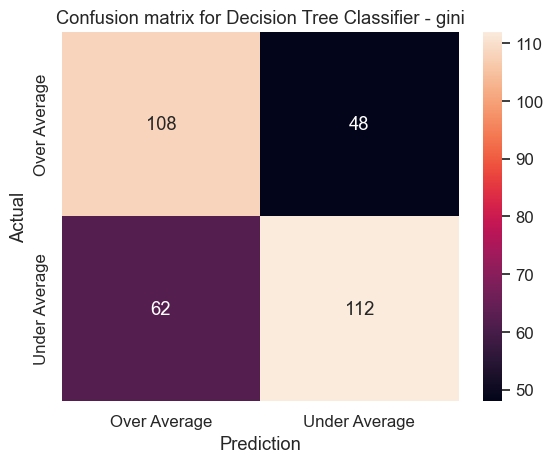

Classification report for Decision Tree Classifier - gini  : 
               precision    recall  f1-score   support

 Over Average       0.64      0.69      0.66       156
Under Average       0.70      0.64      0.67       174

     accuracy                           0.67       330
    macro avg       0.67      0.67      0.67       330
 weighted avg       0.67      0.67      0.67       330

AUC ROC score for Decision Tree Classifier - gini : 0.6679929266136163
----------------------------------------------------------------------------------------------------
Accuracy score for Decision Tree Classifier - entropy  :  0.6757575757575758


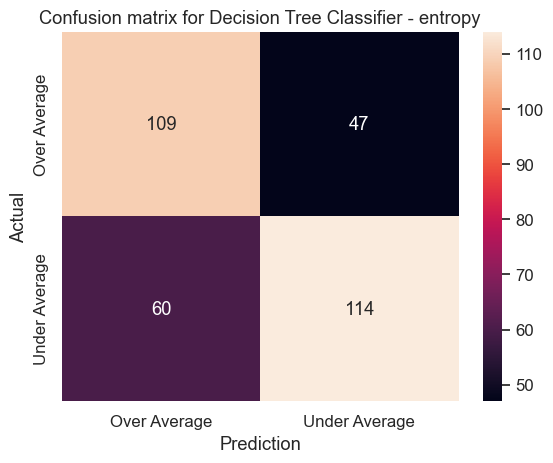

Classification report for Decision Tree Classifier - entropy  : 
               precision    recall  f1-score   support

 Over Average       0.64      0.70      0.67       156
Under Average       0.71      0.66      0.68       174

     accuracy                           0.68       330
    macro avg       0.68      0.68      0.68       330
 weighted avg       0.68      0.68      0.68       330

AUC ROC score for Decision Tree Classifier - entropy : 0.676945181255526
----------------------------------------------------------------------------------------------------
Accuracy score for Decision Tree Classifier - log_loss  :  0.6757575757575758


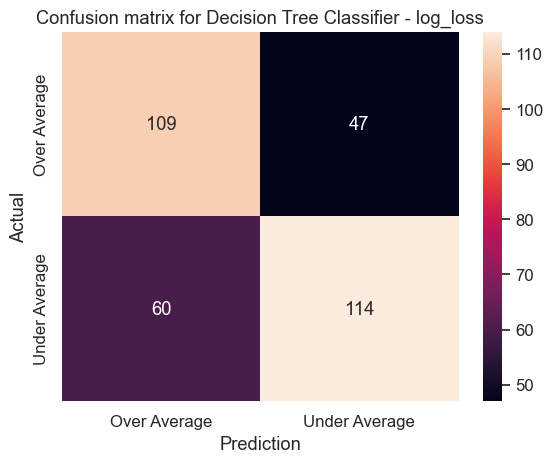

Classification report for Decision Tree Classifier - log_loss  : 
               precision    recall  f1-score   support

 Over Average       0.64      0.70      0.67       156
Under Average       0.71      0.66      0.68       174

     accuracy                           0.68       330
    macro avg       0.68      0.68      0.68       330
 weighted avg       0.68      0.68      0.68       330

AUC ROC score for Decision Tree Classifier - log_loss : 0.676945181255526
----------------------------------------------------------------------------------------------------


In [27]:
#  feature_importances with top scores

feature_df_list = []
eval_scores_list = []

for cri, inner in top_scores.items():
    test_size = inner['Test size']
    
    for index, size in enumerate(sizes):
        if size == test_size:
            X_train_enc = X_train_enc_list[index]
            X_test_enc = X_test_enc_list[index]
            y_train = y_train_list[index]
            y_test = y_test_list[index]
            break
    
    model = DecisionTreeClassifier(criterion=cri, random_state=5)
    model.fit(X_train_enc, y_train)
    
    y_pred = model.predict(X_test_enc)
    y_proba = model.predict_proba(X_test_enc)[:, 1]
    
    eval, eval_scores = getEvaluationMetrics(y_test, y_pred, y_proba)
    showEvaluationMetrics(eval, ('Decision Tree Classifier - ' + cri))
    print('-' * 100)
    eval_scores_list.append(eval_scores)
    
    # feature importances
    importances = model.feature_importances_
    
    col_cri = 'Features_' + str(cri)
    col_imp = 'Importance_' + str(cri)
    
    features_df = pd.DataFrame({col_cri: feature_names, col_imp: importances}).sort_values(col_imp, ascending=False).reset_index(drop=True)
    feature_df_list.append(features_df)

In [28]:
dt_top_scores_eval_df = pd.DataFrame(eval_scores_list, columns=eval_cols, index=criterions)
dt_top_scores_eval_df.to_csv('RQ1/DecisionTreeClassifier_TopAccuracy_Evaluation.csv')
display(dt_top_scores_eval_df)

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
gini,0.666667,0.635294,0.692308,0.662577,156,0.700000,0.643678,0.670659,174,0.667993
entropy,0.675758,0.644970,0.698718,0.670769,156,0.708075,0.655172,0.680597,174,0.676945
log_loss,0.675758,0.644970,0.698718,0.670769,156,0.708075,0.655172,0.680597,174,0.676945


In [29]:
dt_importance_df = pd.DataFrame()
for i in feature_df_list:
    dt_importance_df = pd.concat([dt_importance_df, i], axis=1)

rfc_importance_df.to_csv('RQ1/DecisionTreeClassifier_TopAccuracy_Importance.csv', index=False)
display(dt_importance_df)

,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current status/work history - Subjective status,0.190759,Current status/work history - Subjective status,0.149497,Current status/work history - Subjective status,0.149497
1,GENDER_R,0.061244,GENDER_R,0.047245,GENDER_R,0.047245
2,LNG_HOME,0.034425,ICTHOME,0.034843,ICTHOME,0.034843
3,ICTHOME,0.032132,LNG_HOME,0.030305,LNG_HOME,0.030305
4,ICTWORK,0.022466,NFEHRSNJR,0.027755,NFEHRSNJR,0.027755
...,...,...,...,...,...,...
73,Skill use work - ICT - Experience with compute...,0.000319,Current work - Employee or self-employed,0.001362,Current work - Employee or self-employed,0.001362
74,NATIVESPEAKER,0.000310,Skill use work - ICT - Experience with compute...,0.000440,Skill use work - ICT - Experience with compute...,0.000440
75,Skill use everyday life - ICT - Ever used comp...,0.000000,Skill use everyday life - ICT - Ever used comp...,0.000000,Skill use everyday life - ICT - Ever used comp...,0.000000
76,Skill use everyday life - ICT - Experience wit...,0.000000,Education - Highest qualification - Level of f...,0.000000,Education - Highest qualification - Level of f...,0.000000


## SVM

### Best accuracy

In [30]:
from sklearn import svm
from sklearn.inspection import permutation_importance

In [31]:
# 6-7 minute runtime
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

scores_dict = {}

for ker in kernels:
    scores_dict[ker] = {}

    for size in sizes:
        scores_dict[ker][size] = []
        index = sizes.index(size)
        
        model = svm.SVC(kernel=ker)
        model.fit(X_train_enc_list[index], y_train_list[index])
        
        score = model.score(X_test_enc_list[index], y_test_list[index]) # same as accuracy_score, this just simplifies the whole process
        scores_dict[ker][size] = score

In [32]:
all_scores = []
top_scores = {}

for cri, inner in scores_dict.items():
    max_size = 0
    max_score = 0
    
    print(cri)
    
    for size, acc in inner.items():

        print(size, '-', acc)
        all_scores.append((str(cri), str(size), acc))
        
        if acc > max_score:
            max_score = acc
            max_size = size
    top_scores[cri] = {'Test size': max_size, 'Accuracy': max_score}
    print()

print('Top Scores')

svm_top_scores = top_scores.copy()

print(top_scores)

linear
0.05 - 0.706060606060606
0.1 - 0.7075757575757575
0.15 - 0.7303030303030303
0.2 - 0.7272727272727273
0.25 - 0.7218181818181818
0.3 - 0.7242424242424242

poly
0.05 - 0.6060606060606061
0.1 - 0.6151515151515151
0.15 - 0.6191919191919192
0.2 - 0.6257575757575757
0.25 - 0.6181818181818182
0.3 - 0.6212121212121212

rbf
0.05 - 0.6121212121212121
0.1 - 0.6272727272727273
0.15 - 0.6161616161616161
0.2 - 0.6174242424242424
0.25 - 0.5848484848484848
0.3 - 0.5681818181818182

sigmoid
0.05 - 0.5242424242424243
0.1 - 0.546969696969697
0.15 - 0.5242424242424243
0.2 - 0.5196969696969697
0.25 - 0.4909090909090909
0.3 - 0.509090909090909

Top Scores
{'linear': {'Test size': 0.15, 'Accuracy': 0.7303030303030303}, 'poly': {'Test size': 0.2, 'Accuracy': 0.6257575757575757}, 'rbf': {'Test size': 0.1, 'Accuracy': 0.6272727272727273}, 'sigmoid': {'Test size': 0.1, 'Accuracy': 0.546969696969697}}


In [33]:
svm_all_scores_df = pd.DataFrame(all_scores, columns=['Kernel', 'Test size', 'Highest Accuracy Score'])
svm_all_scores_df.to_csv('RQ1/SVM_AllAccuracyScores.csv', index=False)
display(svm_all_scores_df)

,Kernel,Test size,Highest Accuracy Score
0,linear,0.05,0.706061
1,linear,0.1,0.707576
2,linear,0.15,0.730303
3,linear,0.2,0.727273
4,linear,0.25,0.721818
5,linear,0.3,0.724242
6,poly,0.05,0.606061
7,poly,0.1,0.615152
8,poly,0.15,0.619192
9,poly,0.2,0.625758


### Feature importance

Accuracy score for SVM - linear  :  0.7303030303030303


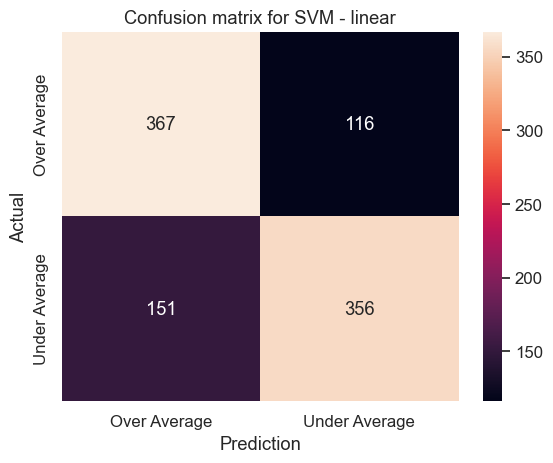

Classification report for SVM - linear  : 
               precision    recall  f1-score   support

 Over Average       0.71      0.76      0.73       483
Under Average       0.75      0.70      0.73       507

     accuracy                           0.73       990
    macro avg       0.73      0.73      0.73       990
 weighted avg       0.73      0.73      0.73       990

AUC ROC score for SVM - linear : 0.804194690482316
----------------------------------------------------------------------------------------------------
Accuracy score for SVM - poly  :  0.6257575757575757


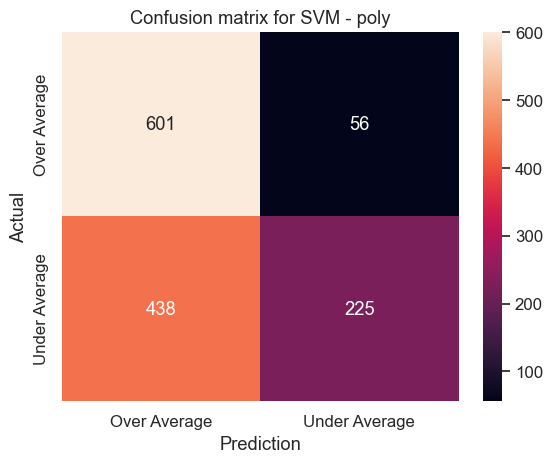

Classification report for SVM - poly  : 
               precision    recall  f1-score   support

 Over Average       0.58      0.91      0.71       657
Under Average       0.80      0.34      0.48       663

     accuracy                           0.63      1320
    macro avg       0.69      0.63      0.59      1320
 weighted avg       0.69      0.63      0.59      1320

AUC ROC score for SVM - poly : 0.6922216023747048
----------------------------------------------------------------------------------------------------
Accuracy score for SVM - rbf  :  0.6272727272727273


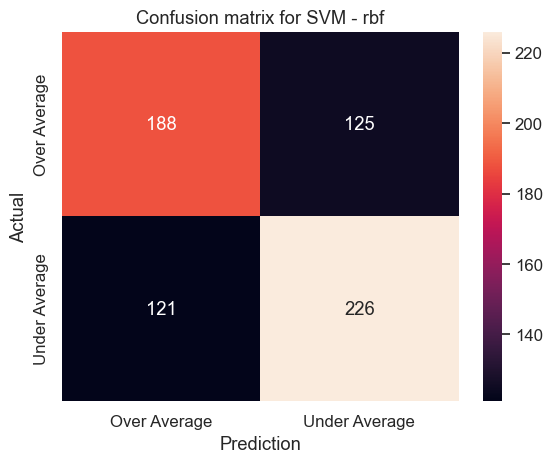

Classification report for SVM - rbf  : 
               precision    recall  f1-score   support

 Over Average       0.61      0.60      0.60       313
Under Average       0.64      0.65      0.65       347

     accuracy                           0.63       660
    macro avg       0.63      0.63      0.63       660
 weighted avg       0.63      0.63      0.63       660

AUC ROC score for SVM - rbf : 0.6991557024610767
----------------------------------------------------------------------------------------------------
Accuracy score for SVM - sigmoid  :  0.546969696969697


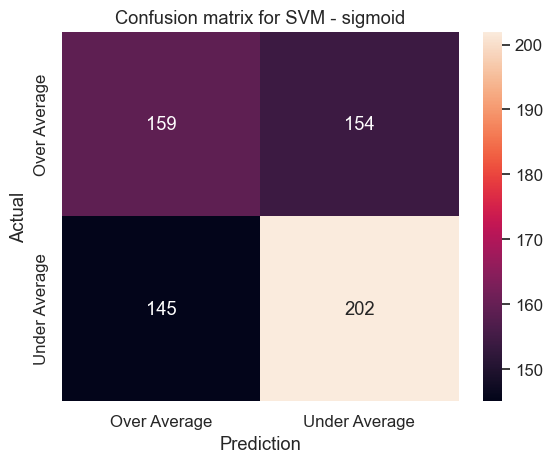

Classification report for SVM - sigmoid  : 
               precision    recall  f1-score   support

 Over Average       0.52      0.51      0.52       313
Under Average       0.57      0.58      0.57       347

     accuracy                           0.55       660
    macro avg       0.55      0.55      0.55       660
 weighted avg       0.55      0.55      0.55       660

AUC ROC score for SVM - sigmoid : 0.5111636942851092
----------------------------------------------------------------------------------------------------


In [34]:
#  feature_importances with top scores
# linear is model.coef_
# others use permutation_importance
# 10 m runtime

feature_df_list = []
eval_scores_list = []

for ker, inner in top_scores.items():
    test_size = inner['Test size']
    
    for index, size in enumerate(sizes):
        if size == test_size:
            X_train_enc = X_train_enc_list[index]
            X_test_enc = X_test_enc_list[index]
            y_train = y_train_list[index]
            y_test = y_test_list[index]
            break
    
    model = svm.SVC(kernel=ker, probability=True)
    model.fit(X_train_enc, y_train)
    
    y_pred = model.predict(X_test_enc)
    y_proba = model.predict_proba(X_test_enc)[:, 1]
    
    eval, eval_scores = getEvaluationMetrics(y_test, y_pred, y_proba)
    showEvaluationMetrics(eval, ('SVM - ' + ker))
    print('-' * 100)
    eval_scores_list.append(eval_scores)
    
    # feature importances
    importances = None
    
    if ker == 'linear':
        importances = model.coef_.flatten()
    else:
        importances = permutation_importance(model, X_test_enc_list[index], y_test_list[index], random_state=5).importances_mean
    
    col_ker = 'Features_' + str(ker)
    col_imp = 'Importance_' + str(ker)
    
    features_df = pd.DataFrame({col_ker: feature_names, col_imp: importances}).sort_values(col_imp, ascending=False).reset_index(drop=True)
    feature_df_list.append(features_df)

In [35]:
svm_top_scores_eval_df = pd.DataFrame(eval_scores_list, columns=eval_cols, index=kernels)
svm_top_scores_eval_df.to_csv('RQ1/SVM_TopAccuracy_Evaluation.csv')
display(svm_top_scores_eval_df)

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
linear,0.730303,0.708494,0.759834,0.733267,483,0.754237,0.702170,0.727273,507,0.804195
poly,0.625758,0.578441,0.914764,0.708726,657,0.800712,0.339367,0.476695,663,0.692222
rbf,0.627273,0.608414,0.600639,0.604502,313,0.643875,0.651297,0.647564,347,0.699156
sigmoid,0.546970,0.523026,0.507987,0.515397,313,0.567416,0.582133,0.574680,347,0.511164


In [36]:
svm_importance_df = pd.DataFrame()
for i in feature_df_list:
    svm_importance_df = pd.concat([svm_importance_df, i], axis=1)

svm_importance_df.to_csv('RQ1/SVM_TopAccuracy_Importance.csv', index=False)
display(svm_importance_df)

,Features_linear,Importance_linear,Features_poly,Importance_poly,Features_rbf,Importance_rbf,Features_sigmoid,Importance_sigmoid
0,Current status/work history - Subjective status,0.388185,Current status/work history - Subjective status,0.072879,Current status/work history - Subjective status,0.025455,NFEHRS,0.037273
1,NATIVESPEAKER,0.346316,NFEHRSNJR,0.018182,NFEHRS,0.010000,NFEHRSJR,0.036667
2,CNTRYID,0.165858,NFEHRSJR,0.008030,LNG_HOME,0.008788,NFEHRSNJR,0.031515
3,Skill use work - ICT - Computer - Level of com...,0.150191,NFEHRS,0.007727,NFEHRSNJR,0.008788,Qualification_Comparision,0.001515
4,Skill use work - How often - Working physicall...,0.113012,Skill use work - How often - Working physicall...,0.004242,Education - Highest qualification - Area of study,0.008182,Current work - Managing other employees - Count,0.001515
...,...,...,...,...,...,...,...,...
73,Current work - Managing other employees,-0.313186,About yourself - Health - State,-0.002424,Skill use work - Problem solving - Complex pro...,-0.004848,Skill use everyday life - ICT - Computer - How...,0.000000
74,Current work - Employee or self-employed,-0.506447,Skill use work - How often - Planning own acti...,-0.002424,NFEHRSJR,-0.004848,VET,0.000000
75,Current work - Employees working for you,-0.520371,Skill use work - How often - Presentations,-0.002879,Skill use work - How often - Negotiating with ...,-0.005152,Skill use work - ICT - Experience with compute...,0.000000
76,Background - Born in country,-0.550901,Current work - Requirements - Education level,-0.003636,Skill use work - ICT - Internet - How often - ...,-0.005758,Skill use work - ICT - Internet - How often - ...,0.000000


# Comparision

## Top accuracy

In [2]:
rfc_top_scores_eval = pd.read_csv('RQ1\RandomForestClassifier_TopAccuracy_Evaluation.csv')
svm_top_scores_eval = pd.read_csv('RQ1\SVM_TopAccuracy_Evaluation.csv')
dt_top_scores_eval = pd.read_csv('RQ1\DecisionTreeClassifier_TopAccuracy_Evaluation.csv')

In [3]:
display(rfc_top_scores_eval)
display(dt_top_scores_eval)
display(svm_top_scores_eval)

,Unnamed: 0,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
0,gini,0.756566,0.736328,0.780538,0.757789,483,0.778243,0.733728,0.755330,507,0.828529
1,entropy,0.752525,0.727969,0.786749,0.756219,483,0.779915,0.719921,0.748718,507,0.821822
2,log_loss,0.752525,0.727969,0.786749,0.756219,483,0.779915,0.719921,0.748718,507,0.821822


,Unnamed: 0,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
0,gini,0.666667,0.635294,0.692308,0.662577,156,0.700000,0.643678,0.670659,174,0.667993
1,entropy,0.675758,0.644970,0.698718,0.670769,156,0.708075,0.655172,0.680597,174,0.676945
2,log_loss,0.675758,0.644970,0.698718,0.670769,156,0.708075,0.655172,0.680597,174,0.676945


,Unnamed: 0,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
0,linear,0.730303,0.708494,0.759834,0.733267,483,0.754237,0.702170,0.727273,507,0.804195
1,poly,0.625758,0.578441,0.914764,0.708726,657,0.800712,0.339367,0.476695,663,0.692222
2,rbf,0.627273,0.608414,0.600639,0.604502,313,0.643875,0.651297,0.647564,347,0.699156
3,sigmoid,0.546970,0.523026,0.507987,0.515397,313,0.567416,0.582133,0.574680,347,0.511164


In [4]:
top_eval = rfc_top_scores_eval[:1]
top_eval = pd.concat([top_eval, dt_top_scores_eval[1:]])
top_eval = pd.concat([top_eval, svm_top_scores_eval[:1]])

top_eval['Model'] = ['RandomForestClassifier_Gini', 'DecisionTreeClassifier_Entropy', 'DecisionTreeClassifier_LogLoss', 'SVM_Linear']

top_eval.set_index('Model', inplace=True)
top_eval.drop(columns='Unnamed: 0', inplace=True)
top_eval

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
Model,,,,,,,,,,
RandomForestClassifier_Gini,0.756566,0.736328,0.780538,0.757789,483,0.778243,0.733728,0.755330,507,0.828529
DecisionTreeClassifier_Entropy,0.675758,0.644970,0.698718,0.670769,156,0.708075,0.655172,0.680597,174,0.676945
DecisionTreeClassifier_LogLoss,0.675758,0.644970,0.698718,0.670769,156,0.708075,0.655172,0.680597,174,0.676945
SVM_Linear,0.730303,0.708494,0.759834,0.733267,483,0.754237,0.702170,0.727273,507,0.804195


In [5]:
top_eval.to_csv('RQ1/all_TopAccuracy_Evaluation.csv')

## Features

In [6]:
rfc_importance = pd.read_csv('RQ1/RandomForestClassifier_TopAccuracy_Importance.csv')
dt_importance = pd.read_csv('RQ1/DecisionTreeClassifier_TopAccuracy_Importance.csv')
svm_importance = pd.read_csv('RQ1/SVM_TopAccuracy_Importance.csv')

In [7]:
display(rfc_importance)
display(dt_importance)
display(svm_importance)

,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current status/work history - Subjective status,0.104349,Current status/work history - Subjective status,0.093441,Current status/work history - Subjective status,0.093441
1,GENDER_R,0.039295,GENDER_R,0.031380,GENDER_R,0.031380
2,ICTHOME,0.030366,ICTHOME,0.031114,ICTHOME,0.031114
3,ICTWORK,0.028993,ICTWORK,0.028774,ICTWORK,0.028774
4,Education - Highest qualification - Area of study,0.024812,Education - Highest qualification - Area of study,0.024597,Education - Highest qualification - Area of study,0.024597
...,...,...,...,...,...,...
73,NATIVESPEAKER,0.002575,Current work - Employee or self-employed,0.002440,Current work - Employee or self-employed,0.002440
74,Skill use everyday life - ICT - Ever used comp...,0.001611,Skill use everyday life - ICT - Experience wit...,0.001518,Skill use everyday life - ICT - Experience wit...,0.001518
75,Skill use everyday life - ICT - Experience wit...,0.001450,Skill use everyday life - ICT - Ever used comp...,0.001312,Skill use everyday life - ICT - Ever used comp...,0.001312
76,Skill use work - ICT - Experience with compute...,0.001432,Skill use work - ICT - Experience with compute...,0.001196,Skill use work - ICT - Experience with compute...,0.001196


,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current status/work history - Subjective status,0.104349,Current status/work history - Subjective status,0.093441,Current status/work history - Subjective status,0.093441
1,GENDER_R,0.039295,GENDER_R,0.031380,GENDER_R,0.031380
2,ICTHOME,0.030366,ICTHOME,0.031114,ICTHOME,0.031114
3,ICTWORK,0.028993,ICTWORK,0.028774,ICTWORK,0.028774
4,Education - Highest qualification - Area of study,0.024812,Education - Highest qualification - Area of study,0.024597,Education - Highest qualification - Area of study,0.024597
...,...,...,...,...,...,...
73,NATIVESPEAKER,0.002575,Current work - Employee or self-employed,0.002440,Current work - Employee or self-employed,0.002440
74,Skill use everyday life - ICT - Ever used comp...,0.001611,Skill use everyday life - ICT - Experience wit...,0.001518,Skill use everyday life - ICT - Experience wit...,0.001518
75,Skill use everyday life - ICT - Experience wit...,0.001450,Skill use everyday life - ICT - Ever used comp...,0.001312,Skill use everyday life - ICT - Ever used comp...,0.001312
76,Skill use work - ICT - Experience with compute...,0.001432,Skill use work - ICT - Experience with compute...,0.001196,Skill use work - ICT - Experience with compute...,0.001196


,Features_linear,Importance_linear,Features_poly,Importance_poly,Features_rbf,Importance_rbf,Features_sigmoid,Importance_sigmoid
0,Current status/work history - Subjective status,0.388185,Current status/work history - Subjective status,0.072879,Current status/work history - Subjective status,0.025455,NFEHRS,0.037273
1,NATIVESPEAKER,0.346316,NFEHRSNJR,0.018182,NFEHRS,0.010000,NFEHRSJR,0.036667
2,CNTRYID,0.165858,NFEHRSJR,0.008030,LNG_HOME,0.008788,NFEHRSNJR,0.031515
3,Skill use work - ICT - Computer - Level of com...,0.150191,NFEHRS,0.007727,NFEHRSNJR,0.008788,Qualification_Comparision,0.001515
4,Skill use work - How often - Working physicall...,0.113012,Skill use work - How often - Working physicall...,0.004242,Education - Highest qualification - Area of study,0.008182,Current work - Managing other employees - Count,0.001515
...,...,...,...,...,...,...,...,...
73,Current work - Managing other employees,-0.313186,About yourself - Health - State,-0.002424,Skill use work - Problem solving - Complex pro...,-0.004848,Skill use everyday life - ICT - Computer - How...,0.000000
74,Current work - Employee or self-employed,-0.506447,Skill use work - How often - Planning own acti...,-0.002424,NFEHRSJR,-0.004848,VET,0.000000
75,Current work - Employees working for you,-0.520371,Skill use work - How often - Presentations,-0.002879,Skill use work - How often - Negotiating with ...,-0.005152,Skill use work - ICT - Experience with compute...,0.000000
76,Background - Born in country,-0.550901,Current work - Requirements - Education level,-0.003636,Skill use work - ICT - Internet - How often - ...,-0.005758,Skill use work - ICT - Internet - How often - ...,0.000000


In [17]:
compare = rfc_importance.iloc[:,:2].add_suffix('_RandomForestClassifier')

dt_compare = dt_importance.iloc[:, 2:].add_suffix('_DecisionTreeClassifier')
compare = pd.concat([compare, dt_compare], axis=1)

svm_compare = svm_importance.iloc[:, :2].add_suffix('_SVM')
compare = pd.concat([compare, svm_compare], axis=1)

In [21]:
compare.to_csv('RQ1/all_TopAccuracy_Importance.csv', index=False)

In [19]:
display('Top 10')
display(compare.head(10))

display('Bottom 10')
display(compare.tail(10))

'Top 10'

,Features_gini_RandomForestClassifier,Importance_gini_RandomForestClassifier,Features_entropy_DecisionTreeClassifier,Importance_entropy_DecisionTreeClassifier,Features_log_loss_DecisionTreeClassifier,Importance_log_loss_DecisionTreeClassifier,Features_linear_SVM,Importance_linear_SVM
0,Current status/work history - Subjective status,0.104349,Current status/work history - Subjective status,0.093441,Current status/work history - Subjective status,0.093441,Current status/work history - Subjective status,0.388185
1,GENDER_R,0.039295,GENDER_R,0.031380,GENDER_R,0.031380,NATIVESPEAKER,0.346316
2,ICTHOME,0.030366,ICTHOME,0.031114,ICTHOME,0.031114,CNTRYID,0.165858
3,ICTWORK,0.028993,ICTWORK,0.028774,ICTWORK,0.028774,Skill use work - ICT - Computer - Level of com...,0.150191
4,Education - Highest qualification - Area of study,0.024812,Education - Highest qualification - Area of study,0.024597,Education - Highest qualification - Area of study,0.024597,Skill use work - How often - Working physicall...,0.113012
5,LNG_HOME,0.021547,LNG_HOME,0.021143,LNG_HOME,0.021143,ISCOSKIL4,0.108504
6,Skill use work - How often - Negotiating with ...,0.020814,NFEHRSJR,0.019806,NFEHRSJR,0.019806,Skill use work - ICT - Computer - Lack of skil...,0.105232
7,CNTRYID,0.018884,Skill use work - How often - Negotiating with ...,0.019160,Skill use work - How often - Negotiating with ...,0.019160,LNG_HOME,0.104244
8,ISCO1C,0.018864,NFEHRS,0.018831,NFEHRS,0.018831,Skill use work - Problem solving - Complex pro...,0.082973
9,Skill use work - How often - Working physicall...,0.018830,ISCO1C,0.018388,ISCO1C,0.018388,Skill use everyday life - ICT - Ever used comp...,0.082866


'Bottom 10'

,Features_gini_RandomForestClassifier,Importance_gini_RandomForestClassifier,Features_entropy_DecisionTreeClassifier,Importance_entropy_DecisionTreeClassifier,Features_log_loss_DecisionTreeClassifier,Importance_log_loss_DecisionTreeClassifier,Features_linear_SVM,Importance_linear_SVM
68,Skill use work - ICT - Computer - Got the skil...,0.004688,Skill use work - Not challenged enough,0.004947,Skill use work - Not challenged enough,0.004947,Current work - Employees working for you - Count,-0.134076
69,Background - Born in country,0.004441,Current status/work history - Current - Paid j...,0.003844,Current status/work history - Current - Paid j...,0.003844,ICTWORK,-0.154768
70,Current status/work history - Current - Paid j...,0.004255,Background - Born in country,0.003520,Background - Born in country,0.003520,Skill use everyday life - ICT - Experience wit...,-0.160453
71,Current work - Employees working for you - Count,0.003802,Current work - Employees working for you - Count,0.003433,Current work - Employees working for you - Count,0.003433,NATIVELANG,-0.168017
72,Current work - Employee or self-employed,0.002936,NATIVESPEAKER,0.002630,NATIVESPEAKER,0.002630,VET,-0.195330
73,NATIVESPEAKER,0.002575,Current work - Employee or self-employed,0.002440,Current work - Employee or self-employed,0.002440,Current work - Managing other employees,-0.313186
74,Skill use everyday life - ICT - Ever used comp...,0.001611,Skill use everyday life - ICT - Experience wit...,0.001518,Skill use everyday life - ICT - Experience wit...,0.001518,Current work - Employee or self-employed,-0.506447
75,Skill use everyday life - ICT - Experience wit...,0.001450,Skill use everyday life - ICT - Ever used comp...,0.001312,Skill use everyday life - ICT - Ever used comp...,0.001312,Current work - Employees working for you,-0.520371
76,Skill use work - ICT - Experience with compute...,0.001432,Skill use work - ICT - Experience with compute...,0.001196,Skill use work - ICT - Experience with compute...,0.001196,Background - Born in country,-0.550901
77,Education - Highest qualification - Level of f...,0.000059,Education - Highest qualification - Level of f...,0.000063,Education - Highest qualification - Level of f...,0.000063,GENDER_R,-0.925268


# END